In [1]:
pip install pandas numpy torch torchvision torchaudio pytorch-lightning matplotlib


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary

import torchvision
from torchvision import transforms
from torchvision.io import read_image
import torchvision.transforms.functional as fn

from torchvision import transforms as T 
from torchvision.transforms import ToTensor

import pytorch_lightning as pl

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))


Using cuda device


In [3]:
class CustomImageDataset(Dataset):
    def __init__(self,
                root: str,
                img_dir: str,):
# #         root: đường dẫn tới thư mục dữ liệu
        self.root = root
        self.img_dir = img_dir
        self.img_data = pd.read_csv(img_dir, names=['X_path', 'labels_path'])

        self.transform = T.Compose([
        #    HistogramNormalize(),
           T.ToPILImage(),
           T.Resize(size = (228, 304)),
#            T.RandomCrop(228),
           T.RandomApply(transforms=[T.RandomVerticalFlip(p=0.3), T.RandomPerspective(distortion_scale=0.8, p=0.2), T.TrivialAugmentWide()], p=0.8),
           T.ToTensor(),
           T.Normalize((0., 0., 0.), (1., 1. , 1.))
        ])

        self.target_transform = T.Compose([
        #    HistogramNormalize(),
           T.ToPILImage(),
           T.Resize(size = (55, 74)),
           T.ToTensor(),
           T.Normalize((0.), (1.))
        ])

    def __len__(self):
        return len(self.img_data['X_path'])

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.img_data.iloc[idx, 0])
        image = read_image(img_path)
        label_path = os.path.join(self.root, self.img_data.iloc[idx, 1])
        label = read_image(label_path)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
#         label = fn.resize(label, size=[14, 15])
        label = label.float().squeeze()*100
        image = image.float().squeeze()*100
        return image, label


In [8]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("soumikrakshit/nyu-depth-v2")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\novax\.cache\kagglehub\datasets\soumikrakshit\nyu-depth-v2\versions\1


In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nguynththanhho/depth-estimate")

print("Path to dataset files:", path)

100%|██████████| 1.19G/1.19G [01:12<00:00, 17.5MB/s]

Extracting files...


Path to dataset files: C:\Users\novax\.cache\kagglehub\datasets\nguynththanhho\depth-estimate\versions\17


In [4]:
class Datamodule(pl.LightningDataModule):
    def __init__(self, batch_size: int):
        super().__init__()

        # Correct paths to the dataset folders
        root = r"C:\Users\novax\.cache\kagglehub\datasets\soumikrakshit\nyu-depth-v2\versions\1\nyu_data"
        train_csv = r"C:\Users\novax\.cache\kagglehub\datasets\nguynththanhho\depth-estimate\versions\17\train.csv"
        test_csv = r"C:\Users\novax\.cache\kagglehub\datasets\nguynththanhho\depth-estimate\versions\17\test.csv"

        self.train_set = CustomImageDataset(root, train_csv)
        self.test_set = CustomImageDataset(root, test_csv)
        self.val_set = CustomImageDataset(root, test_csv)
        self.batch_size = batch_size

    def train_dataloader(self):
        return DataLoader(
            self.train_set,
            batch_size=self.batch_size,
            collate_fn=self.__collate_fn,
            shuffle=True,
            drop_last=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_set,
            batch_size=self.batch_size,
            collate_fn=self.__collate_fn,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_set,
            batch_size=self.batch_size,
            collate_fn=self.__collate_fn,
        )

    def __collate_fn(self, batch):
        x = torch.stack([i[0] for i in batch])
        y = torch.stack([i[1] for i in batch])
        return x, y


In [5]:
batch_size = 32
dm = Datamodule(batch_size)

In [6]:
train_loader = dm.train_dataloader()
test_loader = dm.test_dataloader()

In [ ]:
from torchvision.io import read_image

img = read_image(r"C:\Users\novax\.cache\kagglehub\datasets\soumikrakshit\nyu-depth-v2\versions\1\nyu_data\data\nyu2_train\basement_0001a_out\1.jpg")
print(img.shape)


torch.Size([3, 480, 640])


Feature batch shape: torch.Size([32, 3, 228, 304])
Labels batch shape: torch.Size([32, 55, 74])


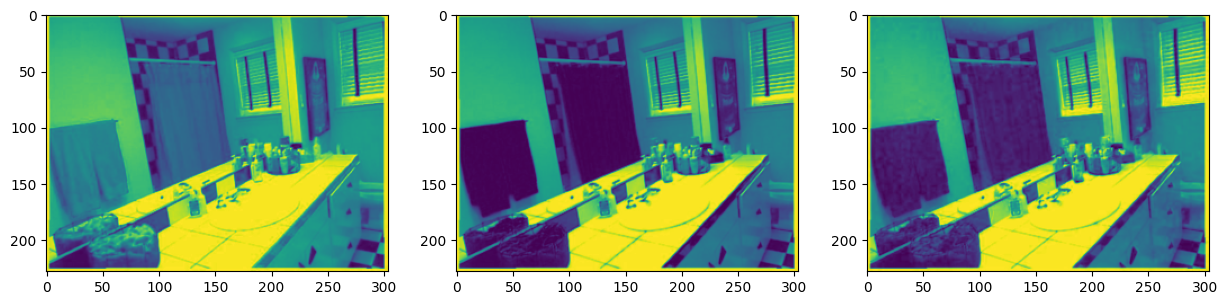

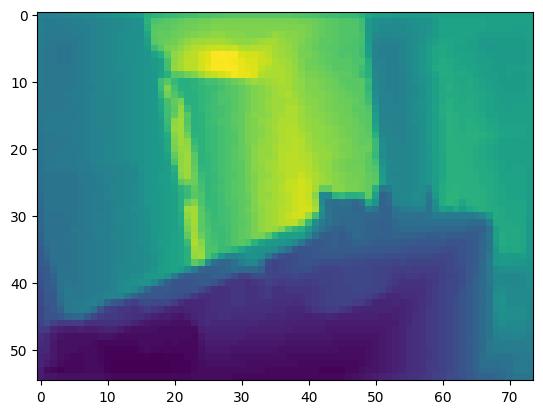

In [ ]:
#rgbsep
def vis(img):
    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    axs[0].imshow(img[0])
    axs[1].imshow(img[1])
    axs[2].imshow(img[2])
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0][0]
vis(img)
plt.show()
plt.imshow(label.resize_([55, 74]))

In [9]:
label.max(), label.min()

(tensor(43.9216), tensor(9.4118))

In [ ]:
#prep
class CNN(nn.Module):
    def __init__(self, kernel = 3,
                 pooling_size = 2,
                 stride = 2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 50, kernel, padding=1)
        self.conv1_bn = nn.BatchNorm2d(50)
        ##
        self.conv2 = nn.Conv2d(50, 50, kernel, padding=1)
        self.conv2_bn = nn.BatchNorm2d(50)
        ##
        self.conv3 = nn.Conv2d(50, 80, kernel, padding=1)
        self.conv3_bn = nn.BatchNorm2d(80)
        ##
        self.conv4 = nn.Conv2d(80, 80, kernel, padding=1)
        self.conv4_bn = nn.BatchNorm2d(80)
        ##
        self.conv5 = nn.Conv2d(80, 100, kernel, padding=1)
        self.conv5_bn = nn.BatchNorm2d(100)
        ##
        self.conv6 = nn.Conv2d(100, 120, kernel, padding=1)
        self.conv6_bn = nn.BatchNorm2d(120)
        self.conv6_trans = nn.ConvTranspose2d(120, 120, kernel_size=[3, 2], stride=2, padding=1)
        ##
        self.conv7 = nn.Conv2d(120, 1, kernel, padding=1)
        self.conv7_bn = nn.BatchNorm2d(1)

    def forward(self, X):
        out1 = self.conv1_bn(F.relu(self.conv1(X)))
        out2 = self.conv2_bn(F.relu(self.conv2(out1)))
        out2 = self.conv2_bn(F.relu(self.conv2(out2)))
        out3 = F.max_pool2d(self.conv3_bn(F.relu(self.conv3(out2))), (2, 2))
        out4 = F.max_pool2d(self.conv4_bn(F.relu(self.conv4(out3))), (2, 2))
        out5 = F.max_pool2d(self.conv5_bn(F.relu(self.conv5(out4))), (2, 2))
        out6 = self.conv6_trans(self.conv6_bn(F.relu(self.conv6(out5))))
        out6 = self.conv7_bn(F.relu(self.conv7(out6)))
        output = out6.view(out6.size(0), 55, 74).squeeze()
        return output
#         out6 = torch.flatten(out6, 1)

In [11]:
summary(CNN().float().cuda(), (3, 228, 304))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 50, 228, 304]           1,400
       BatchNorm2d-2         [-1, 50, 228, 304]             100
            Conv2d-3         [-1, 50, 228, 304]          22,550
       BatchNorm2d-4         [-1, 50, 228, 304]             100
            Conv2d-5         [-1, 50, 228, 304]          22,550
       BatchNorm2d-6         [-1, 50, 228, 304]             100
            Conv2d-7         [-1, 80, 228, 304]          36,080
       BatchNorm2d-8         [-1, 80, 228, 304]             160
            Conv2d-9         [-1, 80, 114, 152]          57,680
      BatchNorm2d-10         [-1, 80, 114, 152]             160
           Conv2d-11          [-1, 100, 57, 76]          72,100
      BatchNorm2d-12          [-1, 100, 57, 76]             200
           Conv2d-13          [-1, 120, 28, 38]         108,120
      BatchNorm2d-14          [-1, 120,

In [ ]:
#cnnwrap for training logic
class Model(pl.LightningModule):
    def __init__(self, lr : float, total_steps: int):
        super().__init__()
        self.lr = lr
        self.model = CNN()
        self.criterion = nn.MSELoss()
        self.total_steps = total_steps
        self.save_hyperparameters()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, betas=(0.9, 0.98), weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=self.lr, total_steps=self.total_steps, verbose=False,
        )
        scheduler = {
            "scheduler": scheduler,
            "interval": "step",  # or 'epoch'
            "frequency": 1,
        }
        return [optimizer], [scheduler]

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        '''
        Hàm này nhận vào một batch
        lấy kết quả của mô hình và tính loss
        mô hình sẽ tự tính back propagation
        '''
        img, labels = batch
        outputs = self.model(img)
        loss = self.criterion(outputs, labels)

        self.log("train_loss", loss.item())
        return loss
    def validation_step(self, batch, batch_idx):
        '''
        Hàm này nhận vào một batch
        lấy kết quả của mô hình và tính loss

        '''
        img, labels = batch
        outputs = self.model(img)
        loss = self.criterion(outputs, labels)

        self.log("train_loss", loss.item())

        # lưu lại loss của validate
        self.log("val_loss", loss.item())
#         self.log("val_acc", acc.item())
        return loss
    def test_step(self, batch, batch_idx):
        img, labels = batch
        outputs = self.model(img)
        loss = self.criterion(outputs, labels)

        self.log("train_loss", loss.item())

        # lưu lại loss của test
        self.log("test_loss", loss.item())
#         self.log("test_acc", acc.item())
        return loss

In [15]:
max_epochs = 15
lr = 0.001
total_steps = len(dm.train_dataloader()) * max_epochs
model = Model(lr=lr, total_steps=total_steps)

In [16]:
wandb_logger = pl.loggers.WandbLogger(
    project="depth_estimation", name='model_CNN_origin_with_mix_data', log_model="all"
)
lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval="step")

trainer = pl.Trainer(
    logger=wandb_logger,
    callbacks=[lr_monitor],
    max_epochs=max_epochs,
    accelerator="auto",
    log_every_n_steps=1,
    gradient_clip_val=2
)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
#log
import wandb
wandb.login(key="09a9c4247d2b76b17cd5ed94ef5daa93b5d81e3a")


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\novax\_netrc
wandb: Currently logged in as: luvhunterxo (luvhunterxo-shiv-nadar-university-chennai) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [18]:
torch.set_float32_matmul_precision('high')


In [ ]:
import torch
torch.set_float32_matmul_precision('high')  # or 'medium' for speed
from pytorch_lightning import Trainer

trainer = Trainer(
    precision="16-mixed",  # enables AMP
    accelerator="gpu",
    devices=1,
    max_epochs=10
)
trainer.fit(model, datamodule=dm)

Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | model     | CNN     | 386 K  | train
1 | criterion | MSELoss | 0      | train
----------------------------------------------
386 K     Trainable params
0         Non-trainable params
386 K     Total params
1.546     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\novax\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\novax\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

In [19]:
PATH = r"C:\Users\novax\.cache\kagglehub\datasets\nguynththanhho\depth-estimate\versions\17\CNN_epoch14.ckpt"
model = Model.load_from_checkpoint(PATH, lr=lr, total_steps=total_steps)


Lightning automatically upgraded your loaded checkpoint from v1.7.2 to v2.5.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\novax\.cache\kagglehub\datasets\nguynththanhho\depth-estimate\versions\17\CNN_epoch14.ckpt`


In [20]:
train_loader = dm.train_dataloader()
test_loader = dm.test_dataloader()

In [21]:
test_features, test_labels = dm.test_set[365]
test_features, test_labels = test_features, test_labels

In [ ]:
#channel,H,W
test_features.shape,test_labels.shape


(torch.Size([3, 228, 304]), torch.Size([55, 74]))

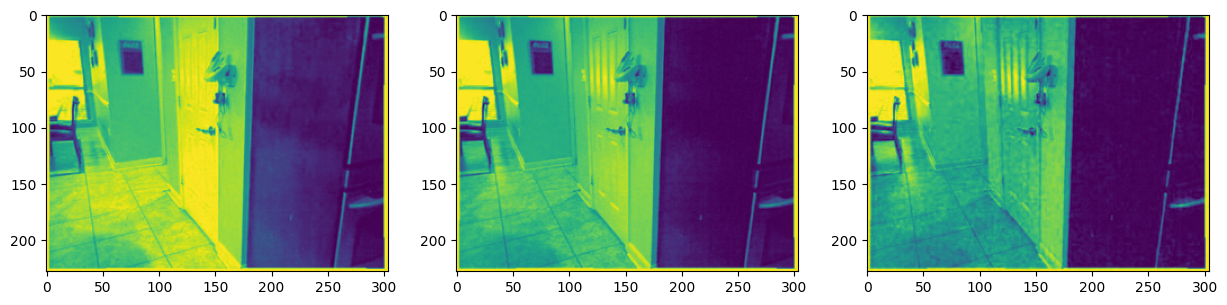

In [23]:
vis(test_features)


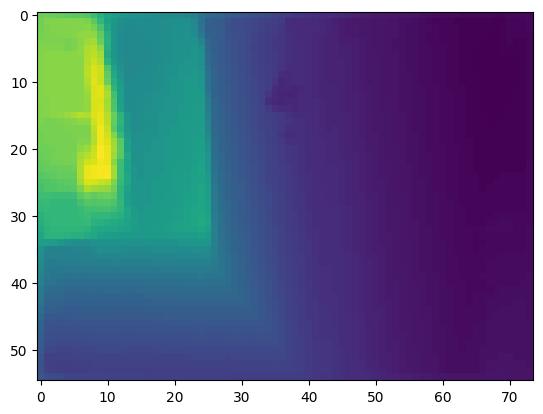

In [24]:
plt.imshow(test_labels.cpu().view(55, 74))


In [25]:
print(test_labels.shape, test_features.shape)


torch.Size([55, 74]) torch.Size([3, 228, 304])


In [26]:
model.eval()


Model(
  (model): CNN(
    (conv1): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_bn): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_bn): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(50, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4_bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv2d(80, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5_bn): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv6): Conv2d(100, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv6_bn): Batc

In [27]:
# Option A: move model to CPU
model.cpu()
with torch.no_grad():
    predict = model(test_features.unsqueeze(0))




In [28]:
predict = model(test_features.cpu().unsqueeze(0))
predict.shape

torch.Size([55, 74])

In [29]:
predict.min()


tensor(0.1364, grad_fn=<MinBackward1>)

In [31]:
loss = nn.MSELoss()
loss(predict.cuda(), test_labels.cuda())

tensor(387.6354, device='cuda:0', grad_fn=<MseLossBackward0>)

In [32]:
predict.max()


tensor(28.9664, grad_fn=<MaxBackward1>)

C:\Users\novax\AppData\Local\Temp\ipykernel_20432\4129470893.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.imshow(torch.tensor(predict.squeeze().cpu()).view(55, 74))


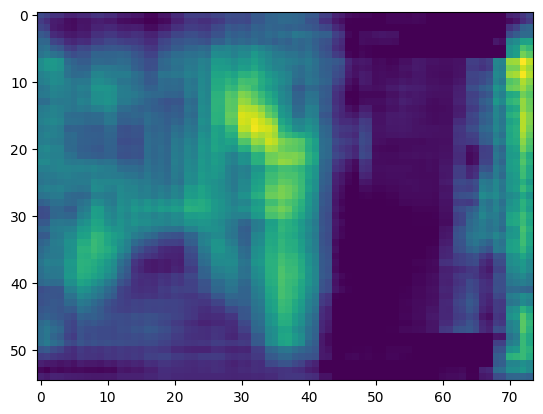

In [33]:
plt.imshow(torch.tensor(predict.squeeze().cpu()).view(55, 74))


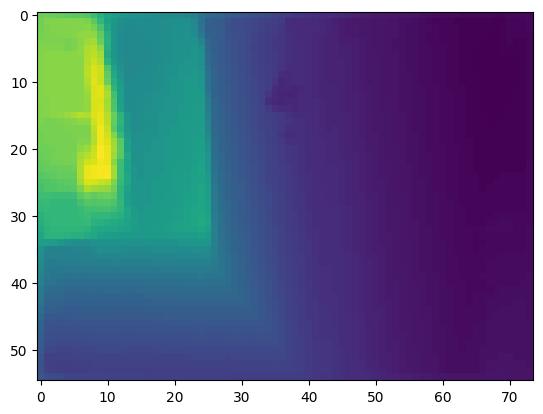

In [34]:
plt.imshow(test_labels.cpu())


In [35]:
def predict_multi(model, X):
    lst = []
    for img in X:
        y = model(img.unsqueeze(0))
        lst.append(y)
#         print(y.unsqueeze(0).shape)
    return lst

In [36]:
def vis_subplot(Yhat, target, inf = "target"):
    fig, axs = plt.subplots(3, 3, figsize=(10, 10))
    k = 0
    loss = nn.MSELoss()
    for i in range(3):
        for j in range(3):
            score = loss(Yhat[k], target[k])
            axs[i, j].imshow(torch.tensor(Yhat[k].squeeze().cpu()).view(55, 74))
            k+=1
            if(inf == "predict"):
                axs[i, j].set_title("Image {}, loss {}".format(k+1, int(score)))
            else:
                axs[i, j].set_title("Image {}".format(k+1))

In [37]:
img_inputs = []
imgs_labels = []
list_predict = []
for i in range(32):
    sample_idx = torch.randint(2000, size=(1,)).item()
    img, img_label = dm.train_set[sample_idx]
    img_inputs.append(img)
    imgs_labels.append(img_label)
    list_predict.append(model(img.unsqueeze(0)))

C:\Users\novax\AppData\Local\Temp\ipykernel_20432\1603918446.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  axs[i, j].imshow(torch.tensor(Yhat[k].squeeze().cpu()).view(55, 74))


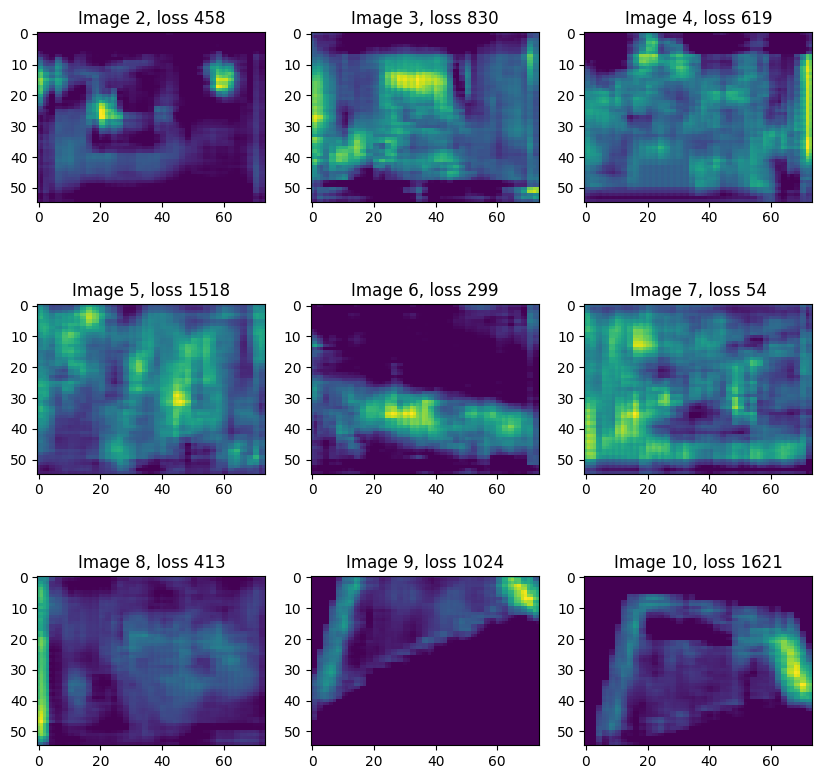

In [38]:
vis_subplot(list_predict, imgs_labels, "predict")


C:\Users\novax\AppData\Local\Temp\ipykernel_20432\1603918446.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  axs[i, j].imshow(torch.tensor(Yhat[k].squeeze().cpu()).view(55, 74))


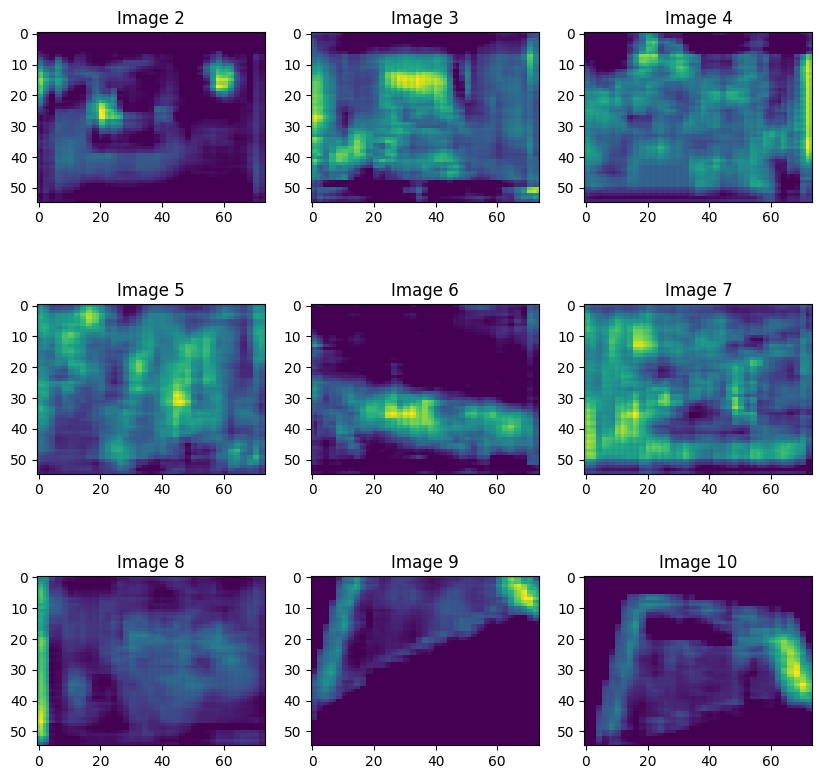

In [39]:
vis_subplot(list_predict, imgs_labels)


C:\Users\novax\AppData\Local\Temp\ipykernel_20432\1603918446.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  axs[i, j].imshow(torch.tensor(Yhat[k].squeeze().cpu()).view(55, 74))


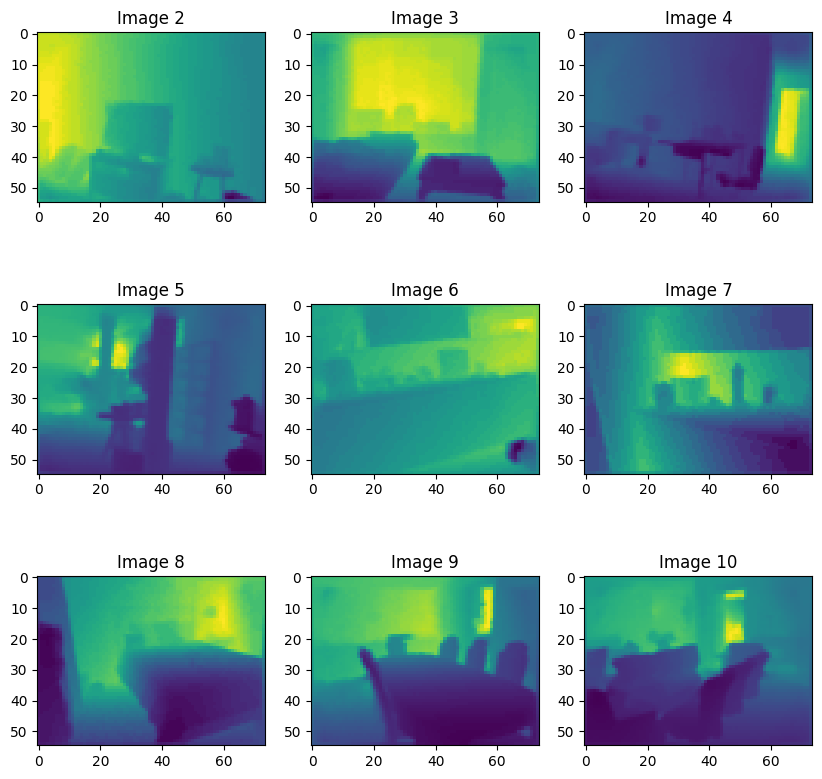

In [40]:
vis_subplot(imgs_labels, imgs_labels)


In [41]:
import torch

# Save model parameters
torch.save(model.state_dict(), 'depth_model_weights.pth')


